In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import statsmodels 
from statsmodels.tsa.exponential_smoothing.ets import ETSModel as ets
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import pymannkendall as mk
import warnings
warnings.filterwarnings("ignore")

In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [3]:
train.sort_values(by="sales", ascending=False).head()

,id,date,store_nbr,family,sales,onpromotion
2163723,2163723,2016-05-02,2,GROCERY I,124717.000,59
2445984,2445984,2016-10-07,39,MEATS,89576.360,0
2144154,2144154,2016-04-21,20,GROCERY I,87438.516,53
2139699,2139699,2016-04-18,45,GROCERY I,76090.000,38
2153031,2153031,2016-04-26,2,GROCERY I,63434.000,30


In [4]:
train["date"]=pd.to_datetime(train["date"], format="%Y-%m-%d")
test["date"]=pd.to_datetime(test["date"], format="%Y-%m-%d")

In [5]:
dataset=train[(train["sales"]>0)].reset_index()
#dataset=train

(array([2.059156e+06, 2.571000e+03, 2.000000e+01, 5.000000e+00,
        1.000000e+00, 1.000000e+00, 1.000000e+00, 2.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([1.22000000e-01, 1.24718098e+04, 2.49434976e+04, 3.74151854e+04,
        4.98868732e+04, 6.23585610e+04, 7.48302488e+04, 8.73019366e+04,
        9.97736244e+04, 1.12245312e+05, 1.24717000e+05]),
 <BarContainer object of 10 artists>)

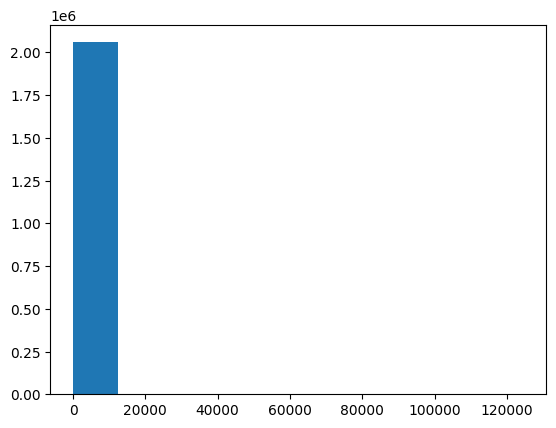

In [6]:
plt.hist(dataset["sales"])

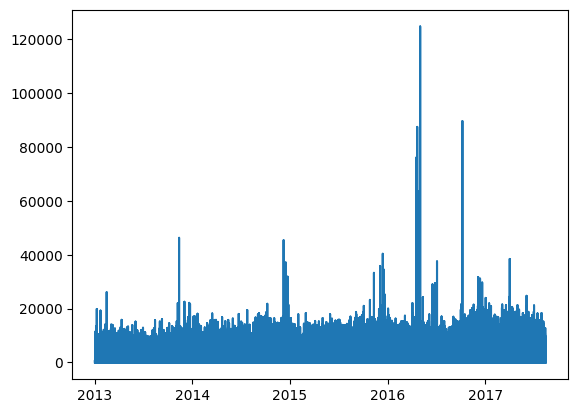

In [7]:
plt.plot(dataset["date"], dataset["sales"])

## Identify Trend

In [8]:
df=dataset[["date", "sales"]].set_index("date")

In [9]:
df['RollingMean'] = df['sales'].rolling(window=3).mean()

Text(0.5, 1.0, 'Trend Detection with Smoothing')

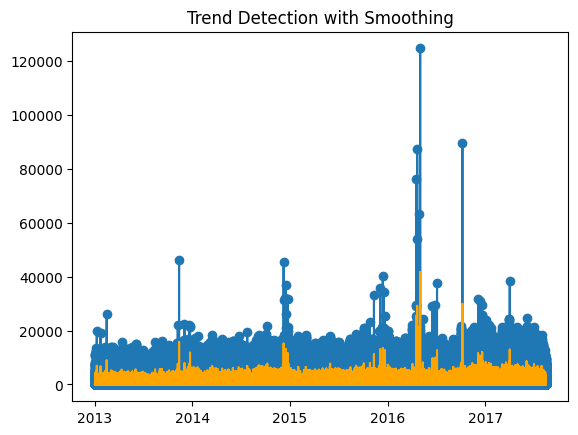

In [10]:
plt.plot(df.index, df['sales'], label='Original', marker='o')
plt.plot(df.index, df['RollingMean'], label='Rolling Mean (window=3)', color='orange')
plt.title('Trend Detection with Smoothing')

## Determine Seasonality

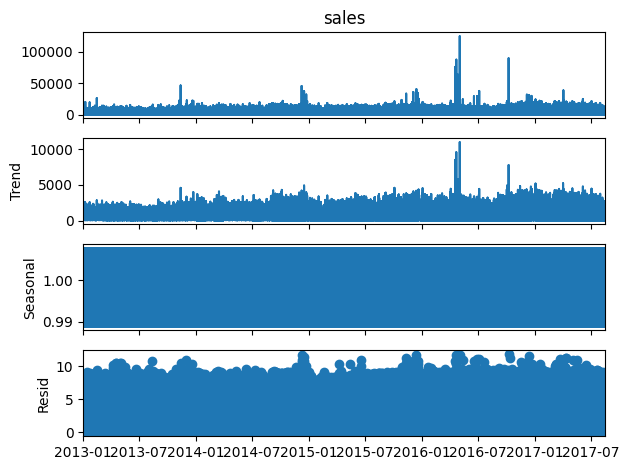

In [11]:
result = seasonal_decompose(df['sales'], model='multiplicative', period=12)
result.plot()
plt.tight_layout()
plt.show()

## ETS Model

In [12]:
model = ets(df['sales'], error='multiplicative', trend='multiplicative', seasonal=None)
fit = model.fit()

In [13]:
forecast = [int(round(i,0)) for i in np.maximum(fit.predict(start=len(df), end=len(df)+len(test)),0)]

In [14]:
test=test.reset_index()

In [15]:
test["sales"]=pd.DataFrame(forecast[1:]).reset_index().iloc[:,1]

In [16]:
test[["id", "sales"]].to_csv("store_sales_submission.csv", index=False)

## ARIMA Model

In [17]:
labeler=LabelEncoder()
labels=labeler.fit_transform(dataset["family"])
dataset["family"]=labels

In [18]:
train_dataset=dataset.drop("id", axis=1)

In [19]:
train_dataset.set_index("date", inplace=True)

In [20]:
train_dataset=train_dataset.drop("index", axis=1)

In [21]:
scaler=StandardScaler()

In [22]:
X=train_dataset[['store_nbr', 'family', 'onpromotion']]
y=train_dataset['sales']

## Determine Stationarity

In [23]:
#KPSS assumes data is stationary, if p-value is less than .05 then non-stationary
stat, p_value, _, _ = kpss(y, regression='c')
print(f'KPSS p-value: {p_value}')

KPSS p-value: 0.01


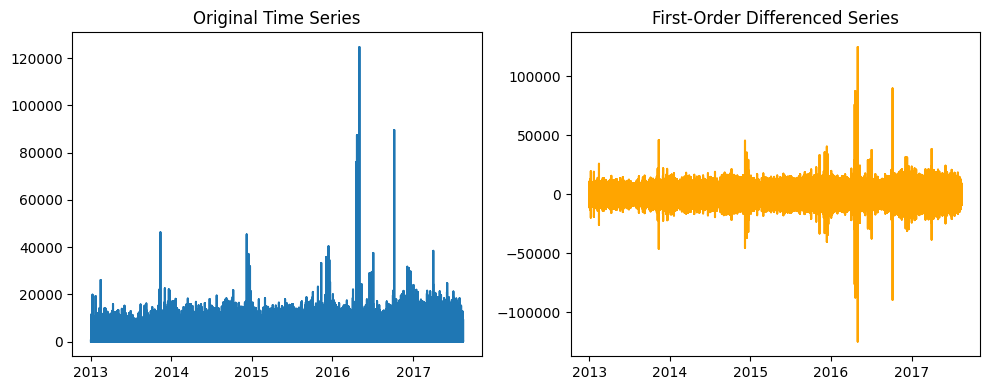

In [24]:
# First-order differencing
ts_diff = y.diff().dropna()

# Plot original vs. differenced series
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(y, label='Original Series')
plt.title('Original Time Series')
plt.subplot(1, 2, 2)
plt.plot(ts_diff, label='Differenced Series', color='orange')
plt.title('First-Order Differenced Series')
plt.tight_layout()
plt.show()

In [25]:
stat, p_value, _, _ = kpss(ts_diff, regression='c')
print(f'KPSS p-value: {p_value}')

KPSS p-value: 0.1


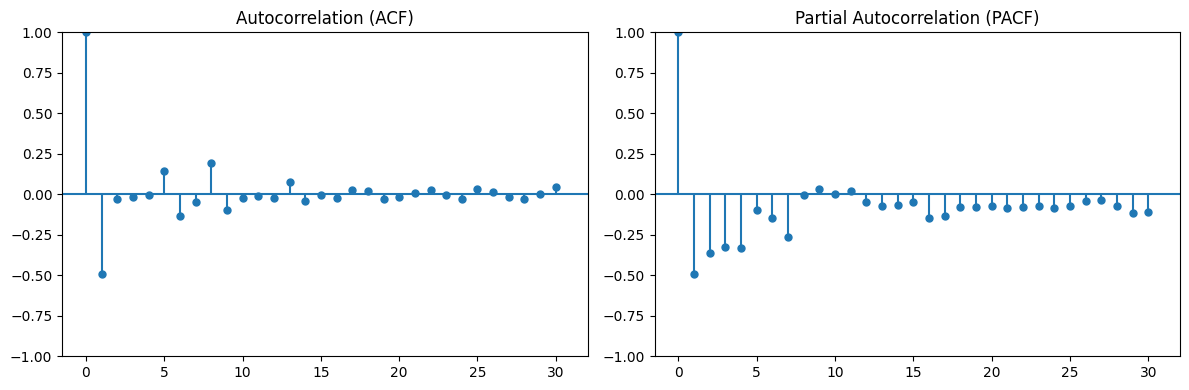

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(ts_diff, ax=axes[0], lags=30)
axes[0].set_title('Autocorrelation (ACF)')

plot_pacf(ts_diff, ax=axes[1], lags=30, method='ywm')
axes[1].set_title('Partial Autocorrelation (PACF)')

plt.tight_layout()
plt.show()

In [27]:
%%time
model = SARIMAX(y, exog=X, order=(1, 1, 1))
fit = model.fit()
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:              2061758
Model:               SARIMAX(1, 1, 1)   Log Likelihood           -17457659.300
Date:                Sat, 13 Sep 2025   AIC                       34915330.599
Time:                        22:45:53   BIC                       34915405.834
Sample:                             0   HQIC                      34915350.722
                            - 2061758                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
store_nbr      -1.1445      0.073    -15.749      0.000      -1.287      -1.002
family        -16.8997      0.083   -203.281      0.000     -17.063     -16.737
onpromotion    37.4005      0.012   2998.397    

In [28]:
test_data=test[['store_nbr', 'family', 'onpromotion', 'date']]
test_data.set_index("date", inplace=True)    

In [29]:
test_data["family"]=labeler.fit_transform(test_data["family"])

In [30]:
forecast = np.maximum(fit.forecast(steps=len(test_data), exog=test_data),0)

In [31]:
forcast2=pd.DataFrame(fit.forecast(steps=1, exog=test_data.iloc[-1, :])).reset_index().iloc[:,1]

In [32]:
forcast2=np.maximum(forcast2,0)

In [33]:
test["sales"]=list(pd.concat([pd.Series(pd.DataFrame(forecast[1:]).reset_index().iloc[:,1]), pd.Series(forcast2)], axis=0))

In [34]:
test[["id", "sales"]].to_csv("store_sales_submission2.csv", index=False)